In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import gzip

# Form our test and train data
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models 
from tensorflow.keras import layers 
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
#
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
# 
from collections import defaultdict


In [4]:
# This is the notebook where I load the data 
f_train_im = gzip.open('train-images-idx3-ubyte.gz','r')
f_train_lab = gzip.open('train-labels-idx1-ubyte.gz','r')
f_test_im = gzip.open('t10k-images-idx3-ubyte.gz','r')
f_test_lab = gzip.open('t10k-labels-idx1-ubyte.gz','r')
image_size = 28
lab_size = 1
n_train = 60000
n_test = 10000
f_train_im.read(16)
f_train_lab.read(8)
f_test_im.read(16)
f_test_lab.read(8)
buf_tr_im = f_train_im.read(image_size * image_size * n_train)
buf_tr_lab = f_train_lab.read(lab_size * n_train)
buf_test_im = f_test_im.read(image_size * image_size * n_test)
buf_test_lab = f_test_lab.read(lab_size * n_train)
train_im = np.frombuffer(buf_tr_im, dtype=np.uint8).astype(np.float32)
train_im = train_im.reshape(n_train, image_size, image_size, 1)
test_im = np.frombuffer(buf_test_im, dtype=np.uint8).astype(np.float32)
test_im = test_im.reshape(n_test, image_size, image_size, 1)
train_labels = np.frombuffer(buf_tr_lab, dtype=np.uint8).astype(np.int64)
train_labels = train_labels.reshape(n_train,1)
test_labels = np.frombuffer(buf_test_lab, dtype=np.uint8).astype(np.int64)
test_labels = test_labels.reshape(n_test,1)

In [5]:
train_im.shape

(60000, 28, 28, 1)

In [6]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [7]:
#make sure data is balanced 
Dictionary_counts = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
total = 0
for i in train_labels:
    digit = i[0]
    Dictionary_counts[digit] +=1
    total +=1
for key in range(10):
    Dictionary_counts[key] = Dictionary_counts[key]/total
print(Dictionary_counts)

{0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1}


In [7]:
print(train_im.shape)
print(test_im.shape)
print(train_labels.shape)
print(test_labels.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 1)
(10000, 1)


In [8]:
# Data Processing
#scaling 
# reshape the data to be able to be scaled 
Train_Im_Reshaped = train_im.reshape(train_im.shape[0],28*28)
Test_Im_Reshaped = test_im.reshape(test_im.shape[0],28*28)
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
scl.fit(Train_Im_Reshaped)
Train_Im_Scaled = scl.transform(Train_Im_Reshaped)
XTest = scl.transform(Test_Im_Reshaped)
#reshape data back to images 
# Train_Im_2d_np = Train_Im_Scaled.reshape(Train_Im_Scaled.shape[0], 28,28,1)
# Test_Im_2d_np  = Test_Im_Scaled.reshape(Test_Im_Scaled.shape[0],28,28,1)
YTrainAll_oneHot = to_categorical(train_labels )
YTest_oneHot = to_categorical(test_labels)
X_Train,X_Val,Y_Train_oneHot,Y_Val_oneHot = train_test_split(Train_Im_Scaled,YTrainAll_oneHot, test_size=0.1, random_state=42, shuffle = True)


In [10]:
XTest.shape

(10000, 784)

In [68]:
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM, BatchNormalization
# from keras.callbacks import TensorBoard
# from keras.callbacks import ModelCheckpoint
# from keras.optimizers import adam

In [109]:
# function for creating a one hidden layer 
def network_1hl_CreateAndFit(nhidden, batchnum, epochs, StopCriteria, lr=0.001):
    # Stop criteria will be a string ; either 'val_loss' or 'val_accuracy'
    nout = 10; #number of output nodes
    SavePath = '1layer_nh' + str(nhidden) + '_LR_'+ str(lr)+ '_SC_' + StopCriteria + '_batch_' + str(batchnum)+'.h5'
    network = models.Sequential()
    network.add(layers.Dense(nhidden,activation='sigmoid',input_shape=(XTest.shape[1],)))
    network.add(layers.Dense(nout, activation = 'softmax'))
#     if optimization == 'adam':
    opt = keras.optimizers.Adam(learning_rate=lr)
#     else if optimization == 'SGD':
#         
# 
# 
    network.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#     network.save_weights('model_init.h5')
    callbacks = [EarlyStopping(monitor=StopCriteria, patience=20),
             ModelCheckpoint(filepath=SavePath, monitor=StopCriteria, save_best_only=True)]
    history = network.fit(X_Train,Y_Train_oneHot,
                      epochs=epochs,
                      batch_size=batchnum,
                      callbacks=callbacks, # Early stopping
                      validation_data=(X_Val,Y_Val_oneHot),
                         verbose = 0)
    return history 

In [90]:
# Test cell
import time
start = time.time()
nhidden = 25; batchnum = 128; StopCriteria = 'val_loss'; epochs = 1000; lr = 0.001
History = network_1hl_CreateAndFit(nhidden, batchnum, epochs, StopCriteria,lr)
end = time.time()
interval = end - start
print(interval/60)

Train on 54000 samples, validate on 6000 samples
Epoch 1/1000
54000/54000 [==============================] - 3s 56us/sample - loss: 1.0579 - acc: 0.7136 - val_loss: 0.6930 - val_acc: 0.7880
Epoch 2/1000
54000/54000 [==============================] - 1s 24us/sample - loss: 0.5867 - acc: 0.8179 - val_loss: 0.5353 - val_acc: 0.8223
Epoch 3/1000
54000/54000 [==============================] - 1s 24us/sample - loss: 0.4880 - acc: 0.8375 - val_loss: 0.4769 - val_acc: 0.8350
Epoch 4/1000
 1920/54000 [>.............................] - ETA: 1s - loss: 0.4753 - acc: 0.8380

KeyboardInterrupt: 

In [78]:
network = load_model('Keras_Model_NH_10_SC_val_loss_batch_128.h5')

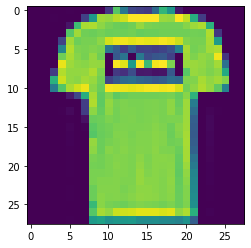

In [11]:
sample = train_im[1,:,:,:]
img = sample.reshape(28,28)
plt.imshow(img)

In [18]:
interval/60

2.5713522752126057

In [26]:
from collections import defaultdict

nhidden_arr = [10,20,30,40,50,60,70,80,90,100,110, 120, 130, 140, 150, 160, 200];
batchnum = 128 ; StopCriteria = 'val_loss'; epochs = 1000;
n = len(nhidden_arr)
# I think the best way to store the results would be in a dictionary
test_acc_diff_nhidden = np.zeros(n)
test_loss_diff_nhidden = np.zeros(n)
d_nhidden = defaultdict(lambda: "Not Present") 
d_nhidden["train_acc_arr"] = defaultdict(lambda: "Not Present")
d_nhidden["train_loss_arr"] = defaultdict(lambda: "Not Present")
d_nhidden["val_acc_arr"] = defaultdict(lambda: "Not Present")
d_nhidden["val_loss_arr"] = defaultdict(lambda: "Not Present")
# loop over hidden layers 
for i in range(n):
    nhidden = nhidden_arr[i]
    print('working on nhidden = '+ str(nhidden))
    # make the network and train the network
    History = network_1hl_CreateAndFit(nhidden, batchnum, epochs, StopCriteria,lr)
    # save the history arrays in the designated dictionary with the key as the number of hidden layers 
    key = str(nhidden)
    d_nhidden["train_acc_arr"][key] = History.history['accuracy']
    d_nhidden["train_loss_arr"][key]  = History.history['loss']
    d_nhidden["val_acc_arr"][key] = History.history['val_accuracy']
    d_nhidden["val_loss_arr"][key] = History.history['val_loss']
    # test the network on the testing data
    #trained network path 
    NetworkPath = 'Keras_1layer_nh' + str(nhidden) + '_SC_' + StopCriteria + '_batch_' + str(batchnum)+'.h5'
    trained_network = load_model(NetworkPath)
    # Use the testing data 
    # Get the overall performance for the test sample
    test_loss, test_acc = trained_network.evaluate(X_Test,YTest_oneHot)
    # save the accuracy and the loss 
    test_acc_diff_nhidden[i] = test_acc
    test_loss_diff_nhidden[i] = test_loss
    

working on nhidden = 10
10000/10000 [==============================] - 0s 45us/step
working on nhidden = 20
10000/10000 [==============================] - 1s 58us/step
working on nhidden = 30
10000/10000 [==============================] - 0s 48us/step
working on nhidden = 40
10000/10000 [==============================] - 1s 54us/step
working on nhidden = 50
10000/10000 [==============================] - 1s 74us/step
working on nhidden = 60
10000/10000 [==============================] - 1s 65us/step
working on nhidden = 70
10000/10000 [==============================] - 1s 69us/step
working on nhidden = 80
10000/10000 [==============================] - 1s 77us/step
working on nhidden = 90
10000/10000 [==============================] - 1s 92us/step
working on nhidden = 100
10000/10000 [==============================] - 1s 134us/step
working on nhidden = 110
10000/10000 [==============================] - 1s 142us/step
working on nhidden = 120
10000/10000 [==============================] - 

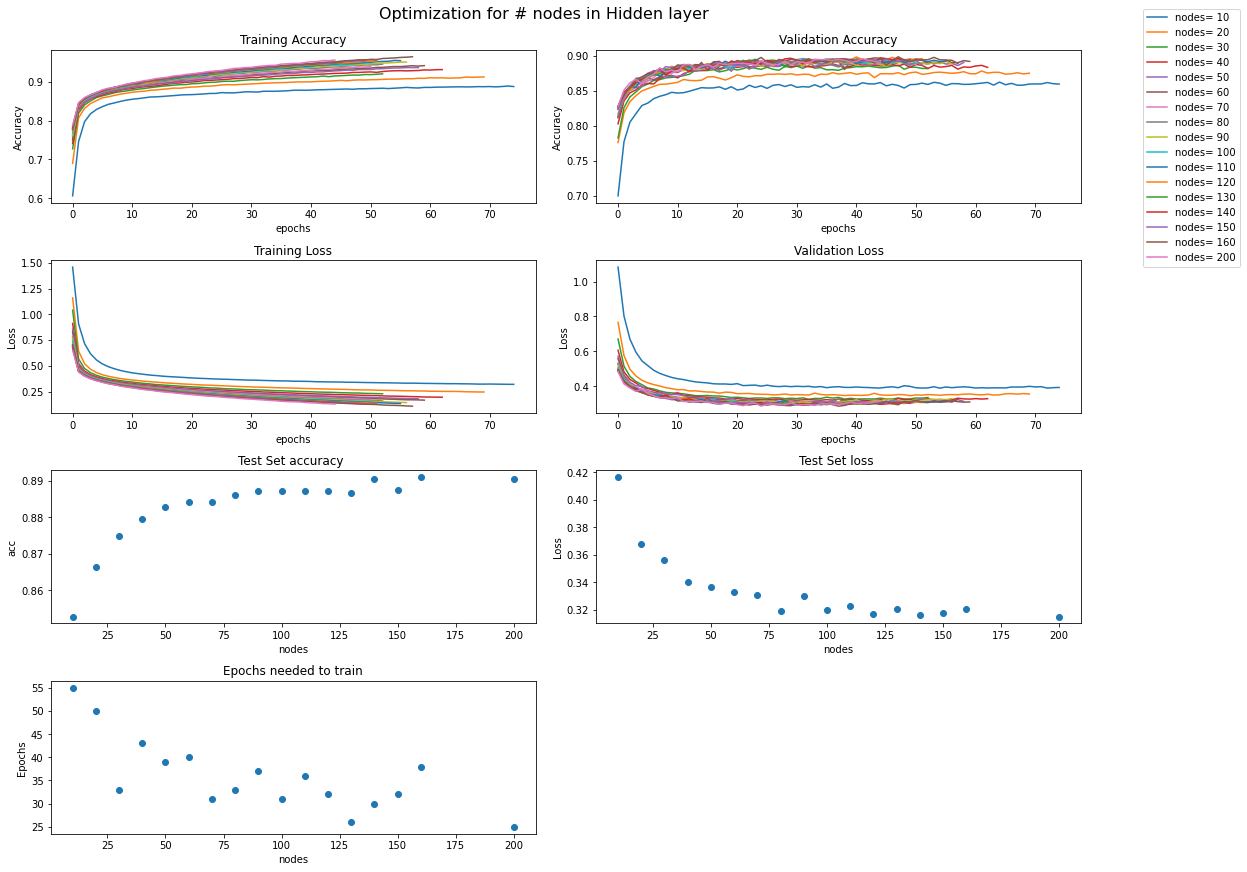

In [29]:
fig, axs = plt.subplots(4, 2,figsize=(15,12), constrained_layout = True)
# fig.tight_layout()
# axs[0, 0].plot(x, y)
axs[0, 0].set_title('Training Accuracy')
axs[0, 1].set_title('Validation Accuracy')
axs[1, 0].set_title('Training Loss')
axs[1, 1].set_title('Validation Loss')
axs[2, 0].set_title('Test Set accuracy ')
axs[2, 1].set_title('Test Set loss ')
axs[3,0].set_title('Epochs needed to train')
n = len(nhidden_arr)
nepochs_arr = np.zeros(n)
for i in range(n):
    nhidden = nhidden_arr[i]
    key = str(nhidden)
    Array1 = d_nhidden["train_acc_arr"][key]
    Array2 = d_nhidden["val_acc_arr"][key]
    Array3 = d_nhidden["train_loss_arr"][key]
    Array4 = d_nhidden["val_loss_arr"][key]
    nepochs_trained = len(Array1)
    nepochs_arr[i] = nepochs_trained - 20;
    axs[0, 0].plot(Array1 )
    axs[0, 1].plot(Array2)
    axs[1,0].plot(Array3)
    axs[1,1].plot(Array4, label ='nodes= '+ key)
    axs[0, 0].set(xlabel='epochs', ylabel = 'Accuracy')
    axs[0, 1].set(xlabel='epochs', ylabel = 'Accuracy')
    axs[1, 0].set(xlabel='epochs', ylabel = 'Loss')
    axs[1, 1].set(xlabel='epochs', ylabel = 'Loss')
axs[2,0].scatter(nhidden_arr, test_acc_diff_nhidden)
axs[2,1].scatter(nhidden_arr, test_loss_diff_nhidden)
axs[2, 0].set(xlabel='nodes', ylabel = 'acc')
axs[2, 1].set(xlabel='nodes', ylabel = 'Loss')
axs[3,0].scatter(nhidden_arr, nepochs_arr)
axs[3, 0].set(xlabel='nodes', ylabel = 'Epochs')
axs[-1, -1].axis('off')
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Optimization for # nodes in Hidden layer', fontsize=16)

plt.show()

In [31]:
max_node_Test_Acc_idx = np.argmax(test_acc_diff_nhidden)
MaxAcc = test_acc_diff_nhidden[max_node_Test_Acc_idx]

In [33]:
print('Nnodes with Max Acc = ', nhidden_arr[max_node_Test_Acc_idx])
print('Maximum accuracy on test set = ',MaxAcc)

Nnodes with Max Acc =  160
Maximum accuracy on test set =  0.890999972820282


In [102]:
# Looping over learning rates and storing the results 
LR_array = [1e-4, 1e-3, 1e-2, .1, 1, 10]
# LR_array = [.1]
batchnum = 128; StopCriteria = 'val_loss'; epochs = 4000; nhidden = 160; 
# I am making the epochs a large number
# make a dictionary to store 
npoints = len(LR_array)
# I think the best way to store the results would be in a dictionary
d_lr = defaultdict(lambda: "Not Present") 
d_lr["train_acc_arr"] = defaultdict(lambda: "Not Present")
d_lr["train_loss_arr"] = defaultdict(lambda: "Not Present")
d_lr["val_acc_arr"] = defaultdict(lambda: "Not Present")
d_lr["val_loss_arr"] = defaultdict(lambda: "Not Present")
# make accuracy and loss list 
test_acc_diff_lr = np.zeros(npoints)
test_loss_diff_lr = np.zeros(npoints)
# loop over hidden layers 
for i in range(npoints):
    lr = LR_array[i]
    print('working on learning rate  = '+ str(lr))
    # make the network and train the network
    History = network_1hl_CreateAndFit(nhidden, batchnum, epochs, StopCriteria, lr)
    # save the history arrays in the designated dictionary with the key as the number of hidden layers 
    key = str(lr)
    d_lr["train_acc_arr"][key] = History.history['acc']
    d_lr["train_loss_arr"][key]  = History.history['loss']
    d_lr["val_acc_arr"][key] = History.history['val_acc']
    d_lr["val_loss_arr"][key] = History.history['val_loss']
    # test the network on the testing data
    #trained network path 
#     NetworkPath = 'Model_LR_'+str(lr)+'nh_' + str(nhidden) + '_SC_' + StopCriteria + '_batch_' + str(batchnum)+'.h5'
    NetworkPath =  '1layer_nh' + str(nhidden) + '_LR_'+ str(lr)+ '_SC_' + StopCriteria + '_batch_' + str(batchnum)+'.h5'
    trained_network = load_model(NetworkPath)
    # Use the testing data 
    # Get the overall performance for the test sample
    test_loss, test_acc = trained_network.evaluate(XTest,YTest_oneHot)
    # save the accuracy and the loss 
    test_acc_diff_lr[i] = test_acc
    test_loss_diff_lr[i] = test_loss
    

working on learning rate  = 0.0001
10000/10000 [==============================] - 1s 95us/sample - loss: 0.3143 - acc: 0.8898
working on learning rate  = 0.001
10000/10000 [==============================] - 1s 75us/sample - loss: 0.3190 - acc: 0.8870
working on learning rate  = 0.01
10000/10000 [==============================] - 1s 74us/sample - loss: 0.3704 - acc: 0.8724
working on learning rate  = 0.1
10000/10000 [==============================] - 1s 74us/sample - loss: 0.6434 - acc: 0.7643
working on learning rate  = 1
10000/10000 [==============================] - 2s 212us/sample - loss: 2.2406 - acc: 0.6542
working on learning rate  = 10
10000/10000 [==============================] - 3s 261us/sample - loss: 109.3515 - acc: 0.1831


In [53]:
History.history

{'loss': [1.2627778443694115,
  0.7568962940573692,
  0.6165579311715232,
  0.5470594841655758,
  0.5055534443673161,
  0.47806857062710656,
  0.458608773259653,
  0.4434655594660176,
  0.4315474117257529,
  0.4215069325185484,
  0.4130472106817696,
  0.4056804891799887,
  0.3992025873106387,
  0.3933152541642388,
  0.38810962297436263,
  0.3832891183263726,
  0.3787168014008138,
  0.37464494898087447,
  0.37071167808026073,
  0.3670688080125385,
  0.3636396639669935,
  0.36025386890189515,
  0.3571700042403407,
  0.354108565720833,
  0.35134354865385425,
  0.34859408704770933,
  0.34590688973251316,
  0.34340819341027073,
  0.3410178817477491,
  0.3387860026334723,
  0.3361077673257225,
  0.3340967887867656,
  0.3320053882814116,
  0.32992193073034287,
  0.3281205328450435,
  0.3260306509046091,
  0.3242731748935249,
  0.322329343503548,
  0.32069838915020227,
  0.3187870690971613,
  0.31715673150908613,
  0.3155727270328336,
  0.31377759302034974,
  0.31221633478171296,
  0.310497382

In [98]:
# from tensorflow import keras
from tensorflow.keras.models import load_model

trained_network = load_model(NetworkPath)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


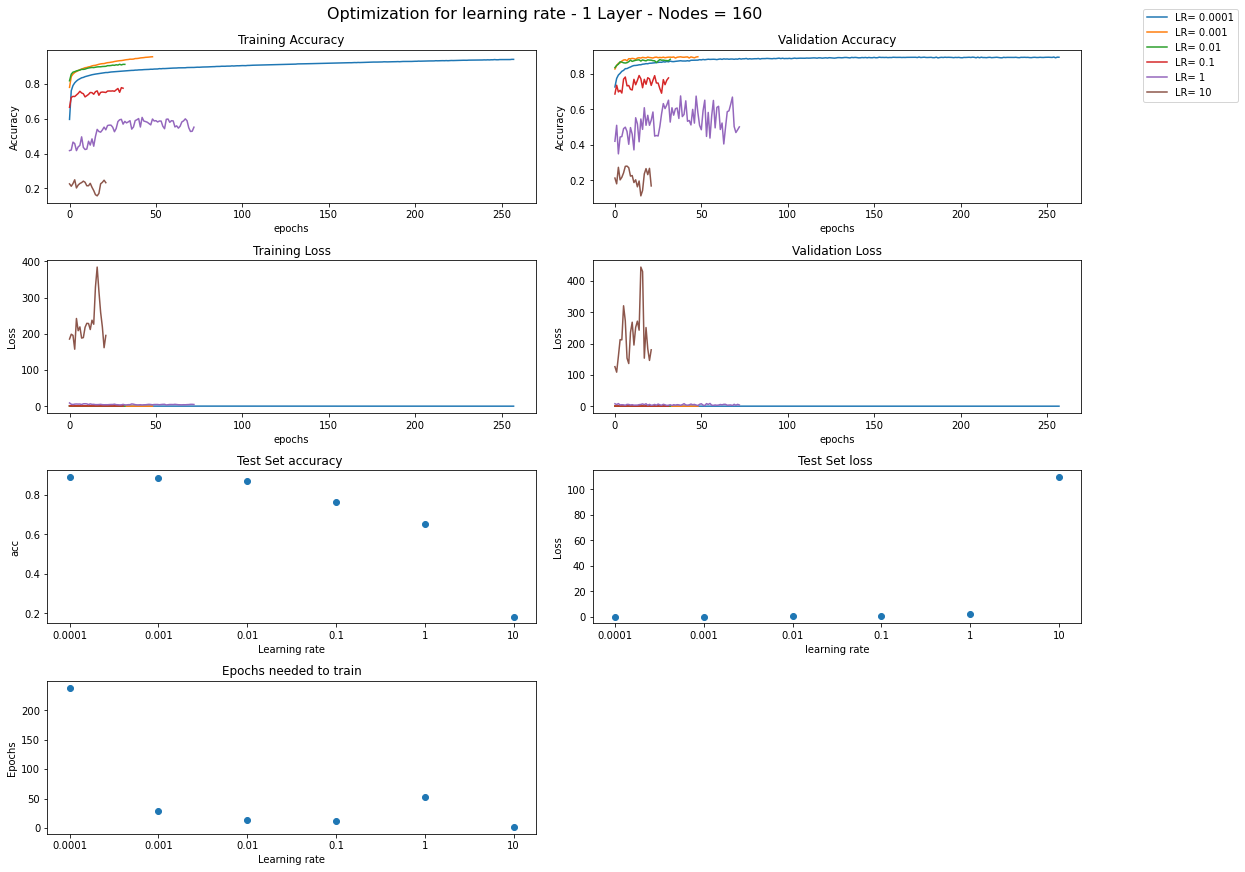

In [105]:
nepochs_arr = np.zeros(npoints)
fig, axs = plt.subplots(4, 2,figsize=(15,12), constrained_layout = True)
# fig.tight_layout()
# axs[0, 0].plot(x, y)
axs[0, 0].set_title('Training Accuracy')
axs[0, 1].set_title('Validation Accuracy')
axs[1, 0].set_title('Training Loss')
axs[1, 1].set_title('Validation Loss')
axs[2, 0].set_title('Test Set accuracy ')
axs[2, 1].set_title('Test Set loss ')
axs[3,0].set_title('Epochs needed to train')
a = np.arange(npoints)
for i in range(npoints):
    lr = LR_array[i]
    key = str(lr)
    Array1 = d_lr["train_acc_arr"][key]
    Array2 = d_lr["val_acc_arr"][key]
    Array3 = d_lr["train_loss_arr"][key]
    Array4 = d_lr["val_loss_arr"][key]
    nepochs_trained = len(Array1)
    nepochs_arr[i] = nepochs_trained - 20;
    axs[0, 0].plot(Array1 )
    axs[0, 1].plot(Array2)
    axs[1,0].plot(Array3)
    axs[1,1].plot(Array4, label ='LR= '+ key)
    axs[0, 0].set(xlabel='epochs', ylabel = 'Accuracy')
    axs[0, 1].set(xlabel='epochs', ylabel = 'Accuracy')
    axs[1, 0].set(xlabel='epochs', ylabel = 'Loss')
    axs[1, 1].set(xlabel='epochs', ylabel = 'Loss')
axs[2,0].scatter(a, test_acc_diff_lr)
axs[2,1].scatter(a, test_loss_diff_lr)
axs[2, 0].set(xlabel='Learning rate', ylabel = 'acc')
axs[2, 1].set(xlabel='learning rate', ylabel = 'Loss')
axs[2, 1].xaxis.set_ticks(a) #set the ticks to be a
axs[2, 1].xaxis.set_ticklabels(LR_array) # change the ticks' names to x
axs[2, 0].xaxis.set_ticks(a) #set the ticks to be a
axs[2, 0].xaxis.set_ticklabels(LR_array) # change the ticks' names to x
axs[3,0].scatter(a, nepochs_arr)
axs[3, 0].set(xlabel='Learning rate', ylabel = 'Epochs')
axs[3, 0].xaxis.set_ticks(a) #set the ticks to be a
axs[3, 0].xaxis.set_ticklabels(LR_array) # change the ticks' names to x
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Optimization for learning rate - 1 Layer - Nodes = 160', fontsize=16)
axs[-1, -1].axis('off')
plt.show()
# ax2.plot(a, y) #we plot y as a function of a, which parametrizes x
# ax2.xaxis.set_ticks(a) #set the ticks to be a
# ax2.xaxis.set_ticklabels(x) # change the ticks' names to x

In [ ]:
# it looks like the best option is 0.001 because it acheives similar accuracy to 0.001 but it takes less to train. 

In [16]:
def network_1hl_CreateAndFit(nhidden, batchnum, epochs, StopCriteria, optimization,lr=0.001):
    # Stop criteria will be a string ; either 'val_loss' or 'val_accuracy'
    nout = 10; #number of output nodes
    SavePath = '1layer_nh' + str(nhidden) + '_LR_'+ str(lr)+ '_SC_' + StopCriteria + '_batch_' + str(batchnum) +'_OPT_' + optimization +'.h5'
    network = models.Sequential()
    network.add(layers.Dense(nhidden,activation='sigmoid',input_shape=(XTest.shape[1],)))
    network.add(layers.Dense(nout, activation = 'softmax'))
    # Optimizer definition
    if optimization == 'adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    elif optimization == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    elif optimization == 'RMSProp':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    elif optimization == 'Adadelta':
        opt = keras.optimizers.Adadelta(learning_rate=lr)
    elif optimization == 'Adagrad':
        opt = keras.optimizers.Adagrad(learning_rate=lr)
    elif optimization == 'Adamax':
        opt = keras.optimizers.Adamax( learning_rate=lr)
# 
# 
    network.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#     network.save_weights('model_init.h5')
    callbacks = [EarlyStopping(monitor=StopCriteria, patience=20),
             ModelCheckpoint(filepath=SavePath, monitor=StopCriteria, save_best_only=True)]
    history = network.fit(X_Train,Y_Train_oneHot,
                      epochs=epochs,
                      batch_size=batchnum,
                      callbacks=callbacks, # Early stopping
                      validation_data=(X_Val,Y_Val_oneHot),
                         verbose = 0)
    return history 

In [17]:
Opt_Arr = ['adam', 'SGD', 'RMSProp', 'Adadelta', 'Adagrad','Adamax']
Opt_Arr[1]

'SGD'

In [20]:
# Looping over learning rates and storing the results 
Opt_Arr = ['adam', 'SGD', 'RMSProp', 'Adadelta', 'Adagrad','Adamax']
# LR_array = [.1]
batchnum = 128; StopCriteria = 'val_loss'; epochs = 500; nhidden = 160; lr = .001;
# I am making the epochs a large number
# make a dictionary to store 
npoints = len(Opt_Arr)
# I think the best way to store the results would be in a dictionary
d_Opt = defaultdict(lambda: "Not Present") 
d_Opt["train_acc_arr"] = defaultdict(lambda: "Not Present")
d_Opt["train_loss_arr"] = defaultdict(lambda: "Not Present")
d_Opt["val_acc_arr"] = defaultdict(lambda: "Not Present")
d_Opt["val_loss_arr"] = defaultdict(lambda: "Not Present")
# make accuracy and loss list 
test_acc_opt = np.zeros(npoints)
test_loss_opt = np.zeros(npoints)
# loop over hidden layers 
for i in range(npoints):
    optimization = Opt_Arr[i]
    print('Training with optimizer ----> '+ optimization)
    # make the network and train the network
    History = network_1hl_CreateAndFit(nhidden, batchnum, epochs, StopCriteria, optimization, lr)
    # save the history arrays in the designated dictionary with the key as the number of hidden layers 
#     key = str(lr)
    d_Opt["train_acc_arr"][optimization] = History.history['acc']
    d_Opt["train_loss_arr"][optimization]  = History.history['loss']
    d_Opt["val_acc_arr"][optimization] = History.history['val_acc']
    d_Opt["val_loss_arr"][optimization] = History.history['val_loss']
    # test the network on the testing data
    #trained network path 
#     NetworkPath = 'Model_LR_'+str(lr)+'nh_' + str(nhidden) + '_SC_' + StopCriteria + '_batch_' + str(batchnum)+'.h5'
    NetworkPath = '1layer_nh' + str(nhidden) + '_LR_'+ str(lr)+ '_SC_' + StopCriteria + '_batch_' + str(batchnum)+'_OPT_'+ optimization+'.h5'
    trained_network = load_model(NetworkPath)
    # Use the testing data 
    # Get the overall performance for the test sample
    test_loss, test_acc = trained_network.evaluate(XTest,YTest_oneHot)
    # save the accuracy and the loss 
    test_acc_opt[i] = test_acc
    test_loss_opt[i] = test_loss
    

Training with optimizer ----> adam
10000/10000 [==============================] - 0s 24us/sample - loss: 0.3160 - acc: 0.8901
Training with optimizer ----> SGD
10000/10000 [==============================] - 0s 27us/sample - loss: 0.4917 - acc: 0.8241
Training with optimizer ----> RMSProp
10000/10000 [==============================] - 0s 27us/sample - loss: 0.3210 - acc: 0.8883
Training with optimizer ----> Adadelta
10000/10000 [==============================] - 0s 27us/sample - loss: 0.5760 - acc: 0.8025
Training with optimizer ----> Adagrad
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
10000/10000 [==============================] - 0s 30us/sample - loss: 0.4717 - acc: 0.8327
Training with optimizer ----> Adamax
10000/10000 [==============================] - 0s 30us/sample - loss: 0.3163 - acc: 0.8882


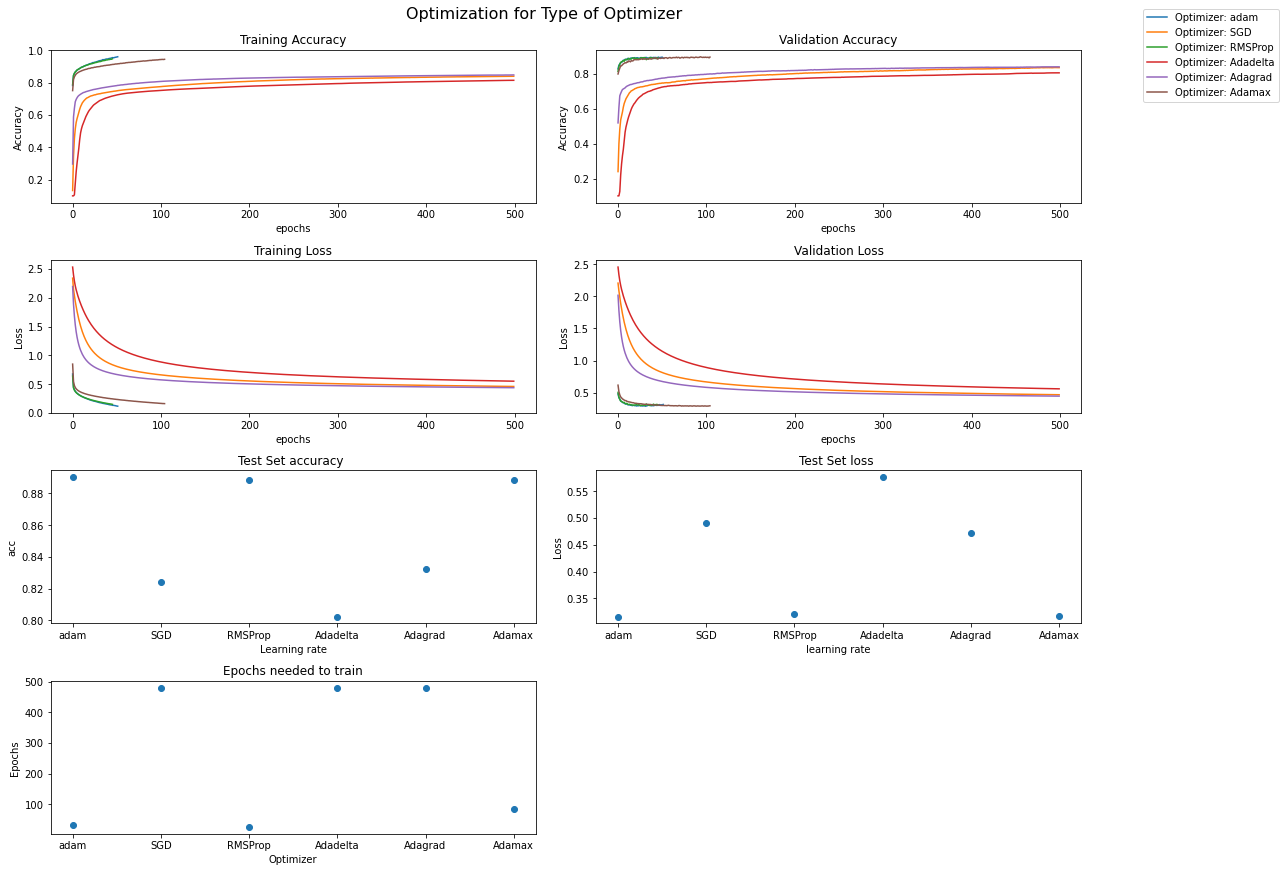

In [24]:
nepochs_arr = np.zeros(npoints)
fig, axs = plt.subplots(4, 2,figsize=(15,12), constrained_layout = True)
# fig.tight_layout()
# axs[0, 0].plot(x, y)
axs[0, 0].set_title('Training Accuracy')
axs[0, 1].set_title('Validation Accuracy')
axs[1, 0].set_title('Training Loss')
axs[1, 1].set_title('Validation Loss')
axs[2, 0].set_title('Test Set accuracy ')
axs[2, 1].set_title('Test Set loss ')
axs[3,0].set_title('Epochs needed to train')
a = np.arange(npoints)
for i in range(npoints):
#     lr = LR_array[i]
    key = Opt_Arr[i]
    Array1 = d_Opt["train_acc_arr"][key]
    Array2 = d_Opt["val_acc_arr"][key]
    Array3 = d_Opt["train_loss_arr"][key]
    Array4 = d_Opt["val_loss_arr"][key]
    nepochs_trained = len(Array1)
    nepochs_arr[i] = nepochs_trained - 20;
    axs[0, 0].plot(Array1 )
    axs[0, 1].plot(Array2)
    axs[1,0].plot(Array3)
    axs[1,1].plot(Array4, label ='Optimizer: '+ key)
    axs[0, 0].set(xlabel='epochs', ylabel = 'Accuracy')
    axs[0, 1].set(xlabel='epochs', ylabel = 'Accuracy')
    axs[1, 0].set(xlabel='epochs', ylabel = 'Loss')
    axs[1, 1].set(xlabel='epochs', ylabel = 'Loss')
axs[2,0].scatter(a, test_acc_opt)
axs[2,1].scatter(a, test_loss_opt)
axs[2, 0].set(xlabel='Optimizer', ylabel = 'acc')
axs[2, 1].set(xlabel='Optimizer', ylabel = 'Loss')
axs[2, 1].xaxis.set_ticks(a) #set the ticks to be a
axs[2, 1].xaxis.set_ticklabels(Opt_Arr) # change the ticks' names to x
axs[2, 0].xaxis.set_ticks(a) #set the ticks to be a
axs[2, 0].xaxis.set_ticklabels(Opt_Arr) # change the ticks' names to x
axs[3,0].scatter(a, nepochs_arr)
axs[3, 0].set(xlabel='Optimizer', ylabel = 'Epochs')
axs[3, 0].xaxis.set_ticks(a) #set the ticks to be a
axs[3, 0].xaxis.set_ticklabels(Opt_Arr) # change the ticks' names to x
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Optimization for Type of Optimizer', fontsize=16)
axs[-1, -1].axis('off')
plt.show()

In [ ]:
# best two is RMS Prop And adam but adam erforms better . 